<center>
<img src="img/logo.jpeg" width=1000 height=800 />
    </center>

In [66]:
import verticapy as vp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from verticapy.learn.ensemble import RandomForestClassifier, XGBoostClassifier
from verticapy.learn.metrics import multilabel_confusion_matrix


%matplotlib inline

In [67]:
# Create new connection with database
vp.new_connection({"host": "localhost",
                   "port": "5433",
                   "database": "VMart",
                   "password": "",
                   "user": "dbadmin"},
                  name="Vertica_New_Connection")
# Connect with the database
vp.connect("Vertica_New_Connection")

In [68]:
# Drop any schema with insurance_data name
vp.drop("insurance", method="schema")
# Create new schema with name insurrance_data
vp.create_schema("insurance", True)

True

## Read dataset

Read and create a Virtual DataFrame of the dataset

The table "insurance"."insurance" has been successfully created.


,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat
1,18,female,20.79,0,❌,southeast,1607.5101
2,18,female,21.66,0,✅,northeast,14283.4594
3,18,female,24.09,1,❌,southeast,2201.0971
4,18,female,25.08,0,❌,northeast,2196.4732
5,18,female,26.315,0,❌,northeast,2198.18985
6,18,female,26.73,0,❌,southeast,1615.7667
7,18,female,27.28,3,✅,southeast,18223.4512
8,18,female,28.215,0,❌,northeast,2200.83085
9,18,female,29.165,0,❌,northeast,7323.734819
10,18,female,30.115,0,❌,northeast,2203.47185

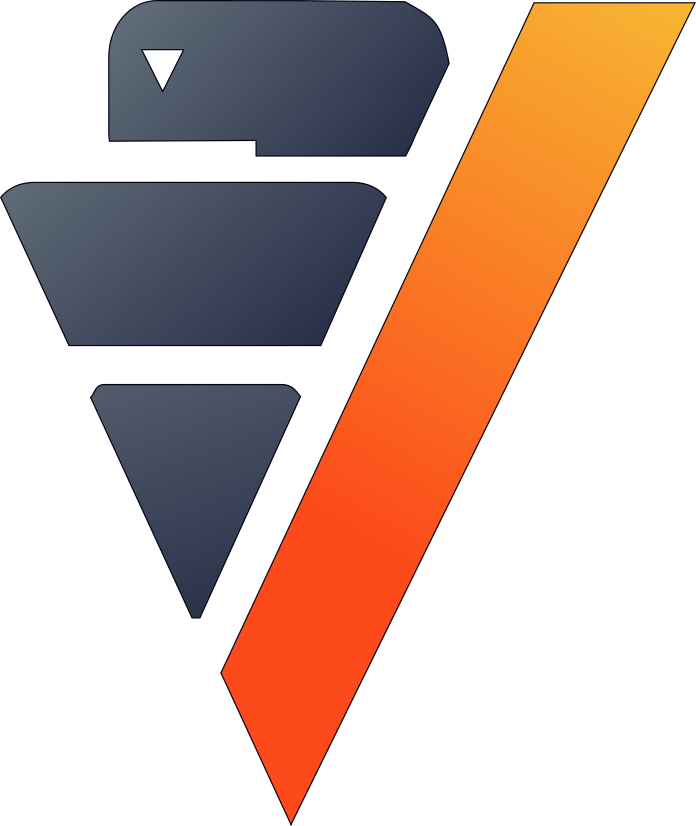

In [69]:
# Read the dataset
insurance_data = vp.read_csv("data/insurance.csv", schema="insurance")
display(insurance_data)

## Data Exploration

First step is to explore the data, as we see the data contains 1338 record with 7 features:
* age: age of the client
* sex: insurance contractor gender: female, male
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of dependent children covered by health insurance
* smoker: whether the client is a smoker or not
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical bill

,count,percent
"""age""",1338.0,100.0
"""sex""",1338.0,100.0
"""bmi""",1338.0,100.0
"""children""",1338.0,100.0
"""smoker""",1338.0,100.0
"""region""",1338.0,100.0
"""charges""",1338.0,100.0

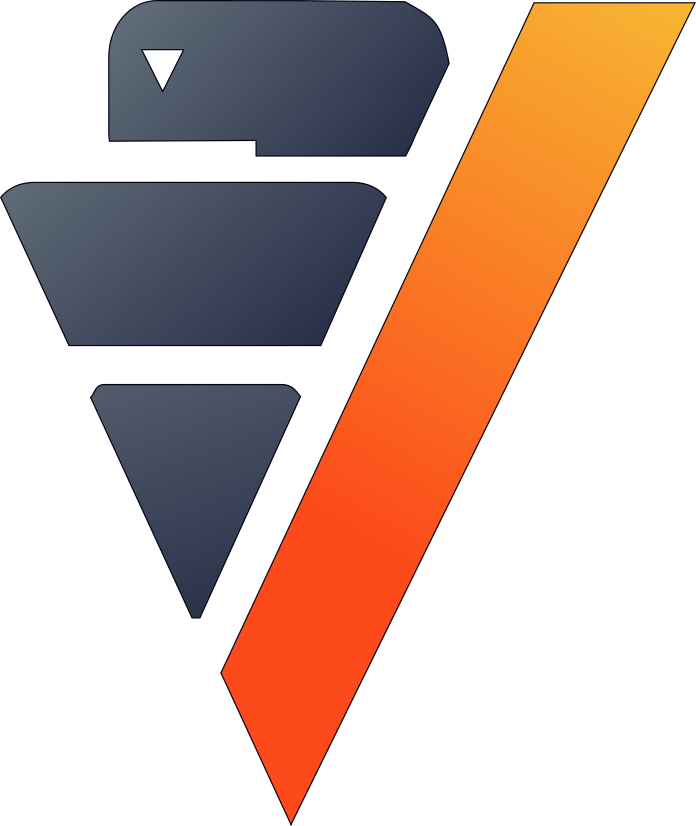

In [70]:
# count the number of non-null entries per column
insurance_data.count_percent()

,approx_unique
"""sex""",2.0
"""smoker""",2.0
"""region""",4.0

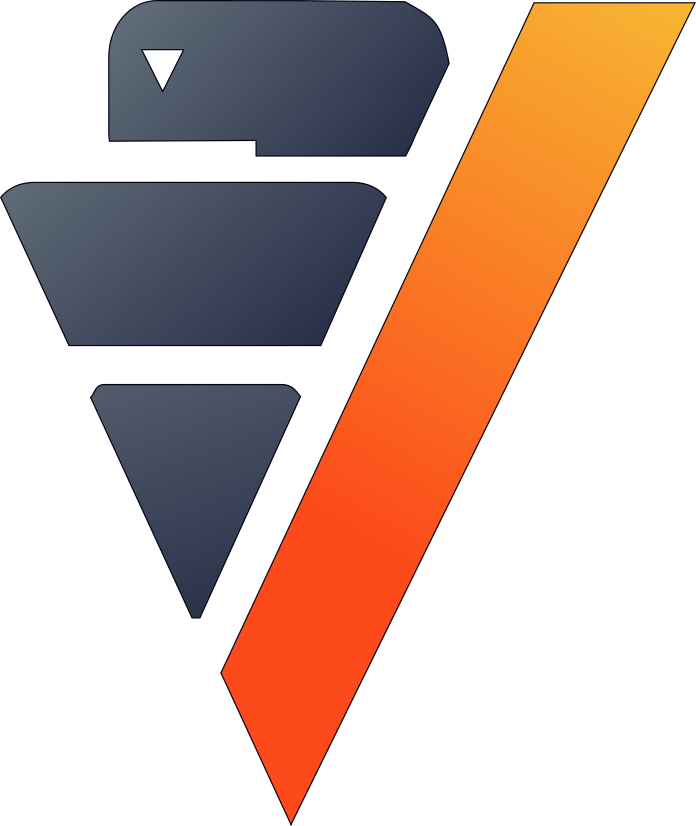

In [71]:
# Check if there are some corrupted values in categorical columns
insurance_data.nunique(columns=["sex",
                                "smoker",
                                "region"])

* The data contains 1338 samples 
* There is no null value or corrupted value in categorical features 

,count,mean,std,min,approx_25%,approx_50%,approx_75%,max
"""age""",1338,39.2070254110613,14.0499603792161,18.0,27.0,39.0,51.0,64.0
"""bmi""",1338,30.6633968609865,6.09818691167901,15.96,26.29625,30.4,34.69375,53.13
"""children""",1338,1.0949177877429,1.20549273978192,0.0,0.0,1.0,2.0,5.0
"""charges""",1338,13270.4222651412,12110.011236694,1121.8739,4740.28715,9379.1847,16639.912515,63770.42801

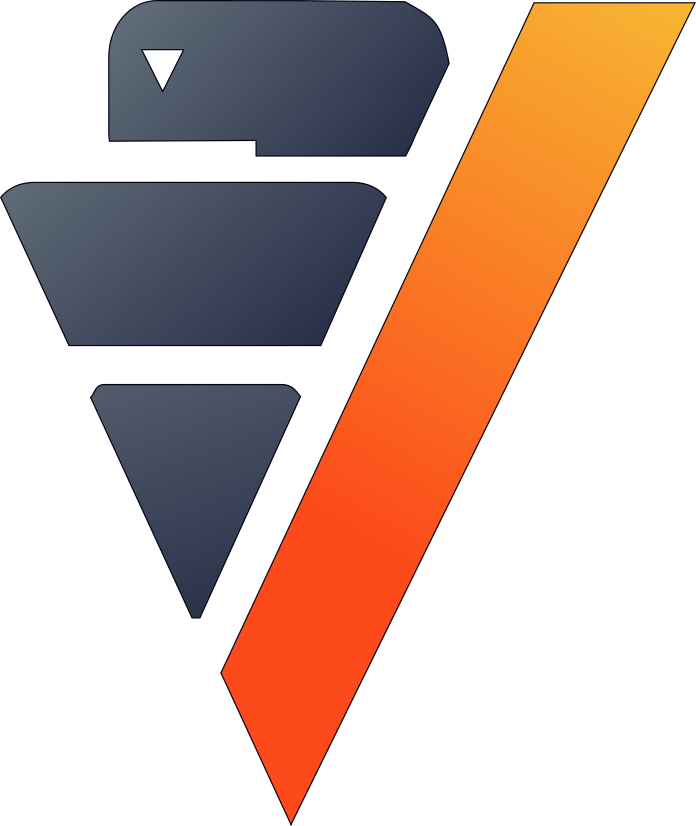

In [72]:
# display description of numerical features
insurance_data[["age", "bmi", "children", "charges"]
               ].describe(method="numerical")

* `age` range between 18 to 64 (adult persons), with average age is 39
* `bmi` range between 15.96 to 53.13
* `children` range between 0 (no child) to 5 
* `charges` goes from 1121 to 63770 with average of 13270

,dtype,count,top,top_percent
"""sex""",varchar(20),1338,male,50.523
"""smoker""",boolean,1338,❌,79.522
"""region""",varchar(20),1338,southeast,27.205

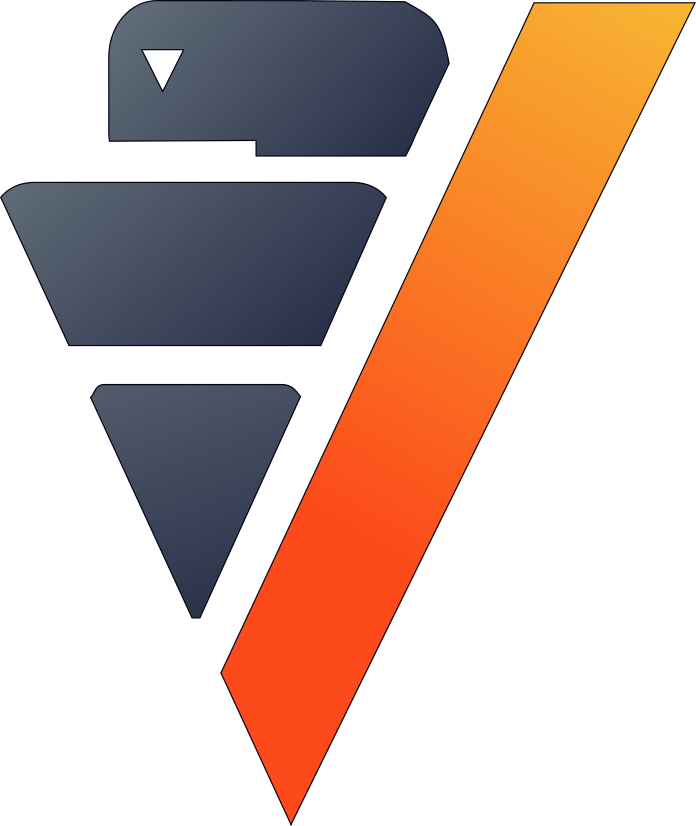

In [73]:
# display description of categorical features
insurance_data[["sex", "smoker", "region"]].describe(method="categorical")

In the following part, we are going to perform univariate and multivariate analysis of different characteristics of the samples like: gender, ages, number of children, smoker or not,.... 

## Univariate and multivariate analysis
### Charges

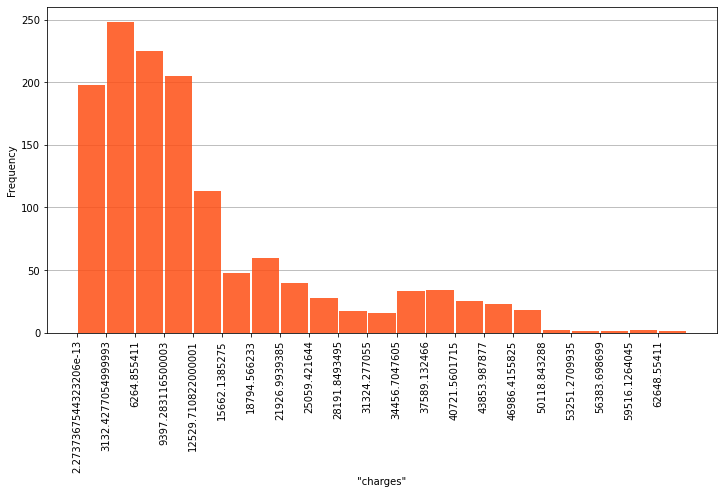

In [74]:
ax = insurance_data["charges"].hist(method="count",
                                    nbins=20,
                                    h=5,
                                    color='#FE5016')

In [75]:
# Boxplot of charges
insurance_data.hchart(x="charges",
                      kind="boxplot",
                      height=300,
                      width=400)

We notice the majority of insurance charges are lower than 20K 

### Gender

In [76]:
# Plot the number of different genders
insurance_data.hchart(x="sex",
                      kind="pie",
                      height=300,
                      width=450)

In [77]:
# Plot the average charges for different gender
insurance_data.hchart(x="sex",
                      y="sex",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=300,
                      width=450)

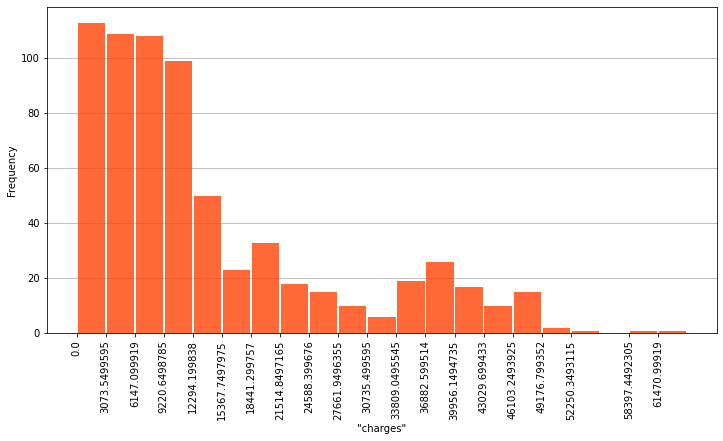

In [161]:
# distribution of charges of males
ax = insurance_data[insurance_data['sex'] == 'male']['charges'].hist(method="count",
                                                                nbins=20,
                                                                h=5,
                                                                color='#FE5016')

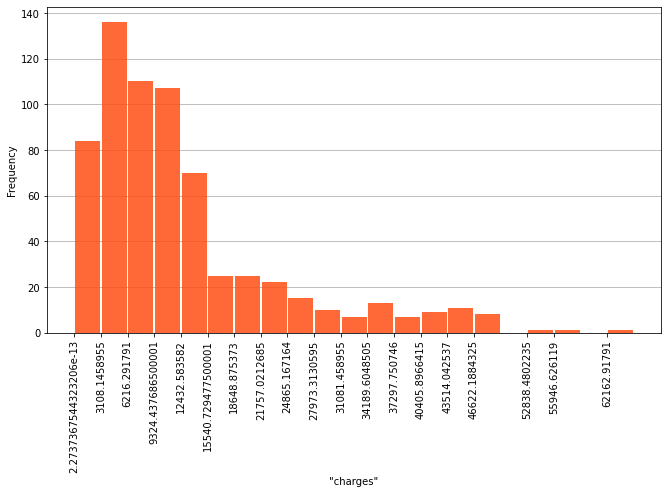

In [162]:
# distribution of charges of females
ax = insurance_data[insurance_data['sex'] == 'female']['charges'].hist(method="count",
                                                                  nbins=20,
                                                                  h=5,
                                                                  color='#FE5016')

The genders have equal representation within the dataset (almost 50%). Moreover,  We can see that the average of charges withing females is lower that the male one.
- We might assume that the gender has a very slight effect on the insurance charges.

### Smoker

We will add a column for visualization purposes to display the tags `smoker` and `none smoker` in our charts 

,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat,Abcsmoker_statusVarchar(11)
1,18,female,20.79,0,❌,southeast,1607.5101,none smoker
2,18,female,21.66,0,✅,northeast,14283.4594,smoker
3,18,female,24.09,1,❌,southeast,2201.0971,none smoker
4,18,female,25.08,0,❌,northeast,2196.4732,none smoker
5,18,female,26.315,0,❌,northeast,2198.18985,none smoker
6,18,female,26.73,0,❌,southeast,1615.7667,none smoker
7,18,female,27.28,3,✅,southeast,18223.4512,smoker
8,18,female,28.215,0,❌,northeast,2200.83085,none smoker
9,18,female,29.165,0,❌,northeast,7323.734819,none smoker
10,18,female,30.115,0,❌,northeast,2203.47185,none smoker

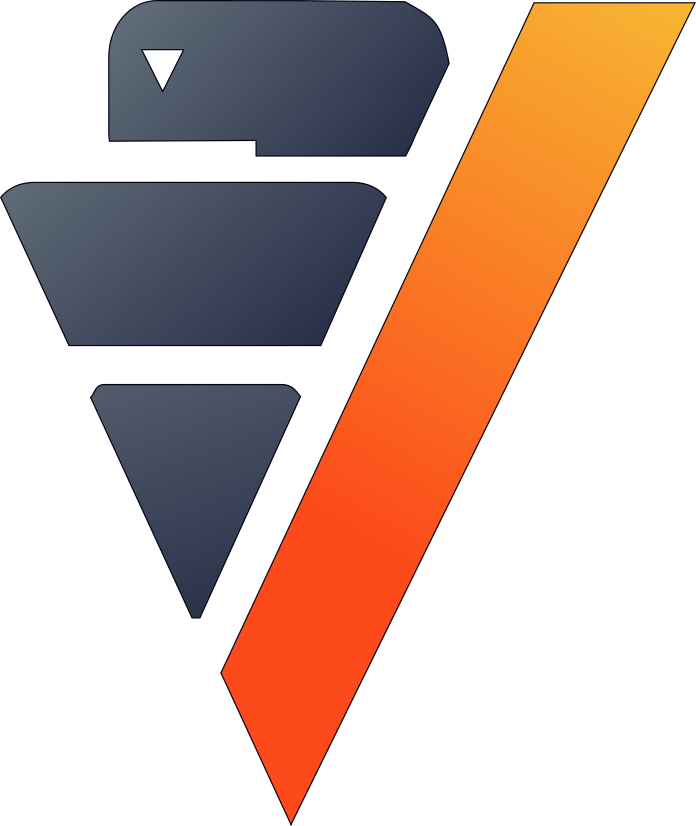

In [78]:
# Add column smoker_status for visualization purposes
insurance_data.case_when("smoker_status",
                         insurance_data["smoker"] == 1, "smoker",
                         "none smoker")

In [79]:
# Plot the count of somker and none smokers
insurance_data.hchart(x="smoker_status",
                      kind="pie",
                      height=300,
                      width=450)

In [80]:
# Plot the average charges for smoker and
# none smokers
insurance_data.hchart(x="smoker_status",
                      y="smoker_status",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=300,
                      width=450)

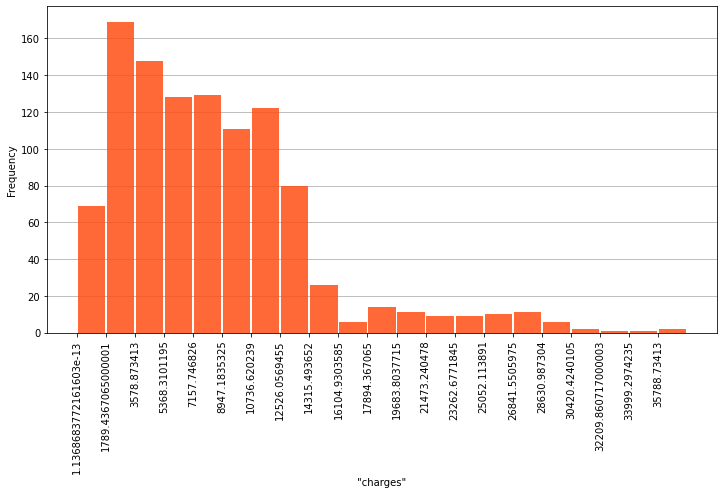

In [166]:
# distribution of charges of none smokers
ax = insurance_data[insurance_data['smoker_status']\
                    == 'none smoker']['charges'].hist(method="count",
                                                      nbins=20,
                                                      h=5,
                                                      color='#FE5016')

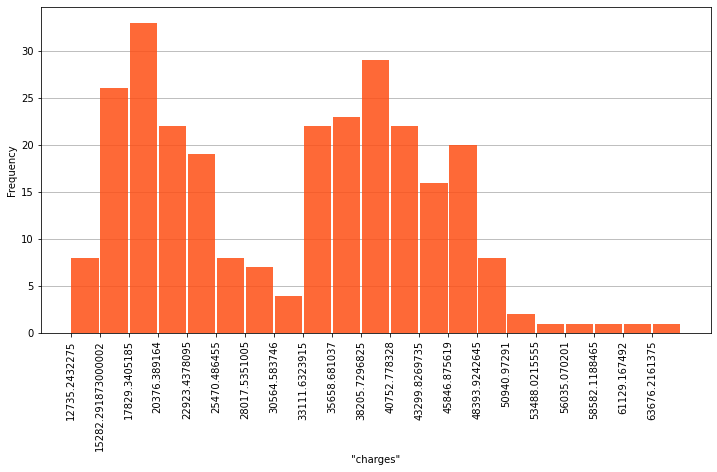

In [164]:
# distribution of charges of smokers
ax = insurance_data[insurance_data['smoker_status']
                    == 'smoker']['charges'].hist(method="count",
                                                 nbins=20,
                                                 h=5,
                                                 color='#FE5016')

* The `smoker` individuals represent __20%__ of the samples and `none smoker` represent __80%__.
* It is clear that the average charges of smoker person are almost __4 time__ higher by __32K__ than none smoker person with average of __8.5K__. From this observation we can say that `smoking status` of a person is highly affecting the insurance charges.

In [81]:
# Distribution of the smoker withing gender
insurance_data.hchart(x="smoker_status",
                      y="sex",
                      z="COUNT(sex)",
                      kind="bar",
                      height=250,
                      width=400)

In [82]:
# The average charges for smoker withing genders
insurance_data.hchart(x="smoker_status",
                      y="sex",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=250,
                      width=400)

We observe that there is more smoking women than men in the samples, however, the average charges of smoking men is higher than the women's one. We can say that our assumption about the relation between gender and charges is present in this case also.

### Number of children 

In [180]:
# Plot the distribution of number of dependent
# children
insurance_data.hchart(x="children",
                      y="children",
                      z="COUNT(children) AS frequency",
                      kind="bar",
                      height=300,
                      width=450)

In [84]:
# Plot the distribution of number of dependent
# children
insurance_data.hchart(x="children",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      y="children",
                      kind="bar",
                      height=300,
                      width=450)

* We see that the people with children have the more insurance charges than individuals, specially the parents with 2, 3, and 4 kids, which is normal, because more people normally means more insurance charges. However, the parents with 5 children have lower charges.

In [85]:
# Boxplot for charges with respect to number
# of children
insurance_data.hchart(x="charges",
                      y="children",
                      kind="boxplot",
                      height=300,
                      width=450)

In [86]:
# Add a new feature children Status
# insurance_data.drop(columns=['children_status'])
insurance_data.case_when("children_status",
                         insurance_data["children"] == 0, "no children",
                         "has children")
# Plot number of people with or without childre w.r.t gender
insurance_data.hchart(x="children_status",
                      y="sex",
                      z="COUNT(sex)",
                      kind="bar",
                      height=250,
                      width=450)

* The distribution of parents with respect to gender is almost the same

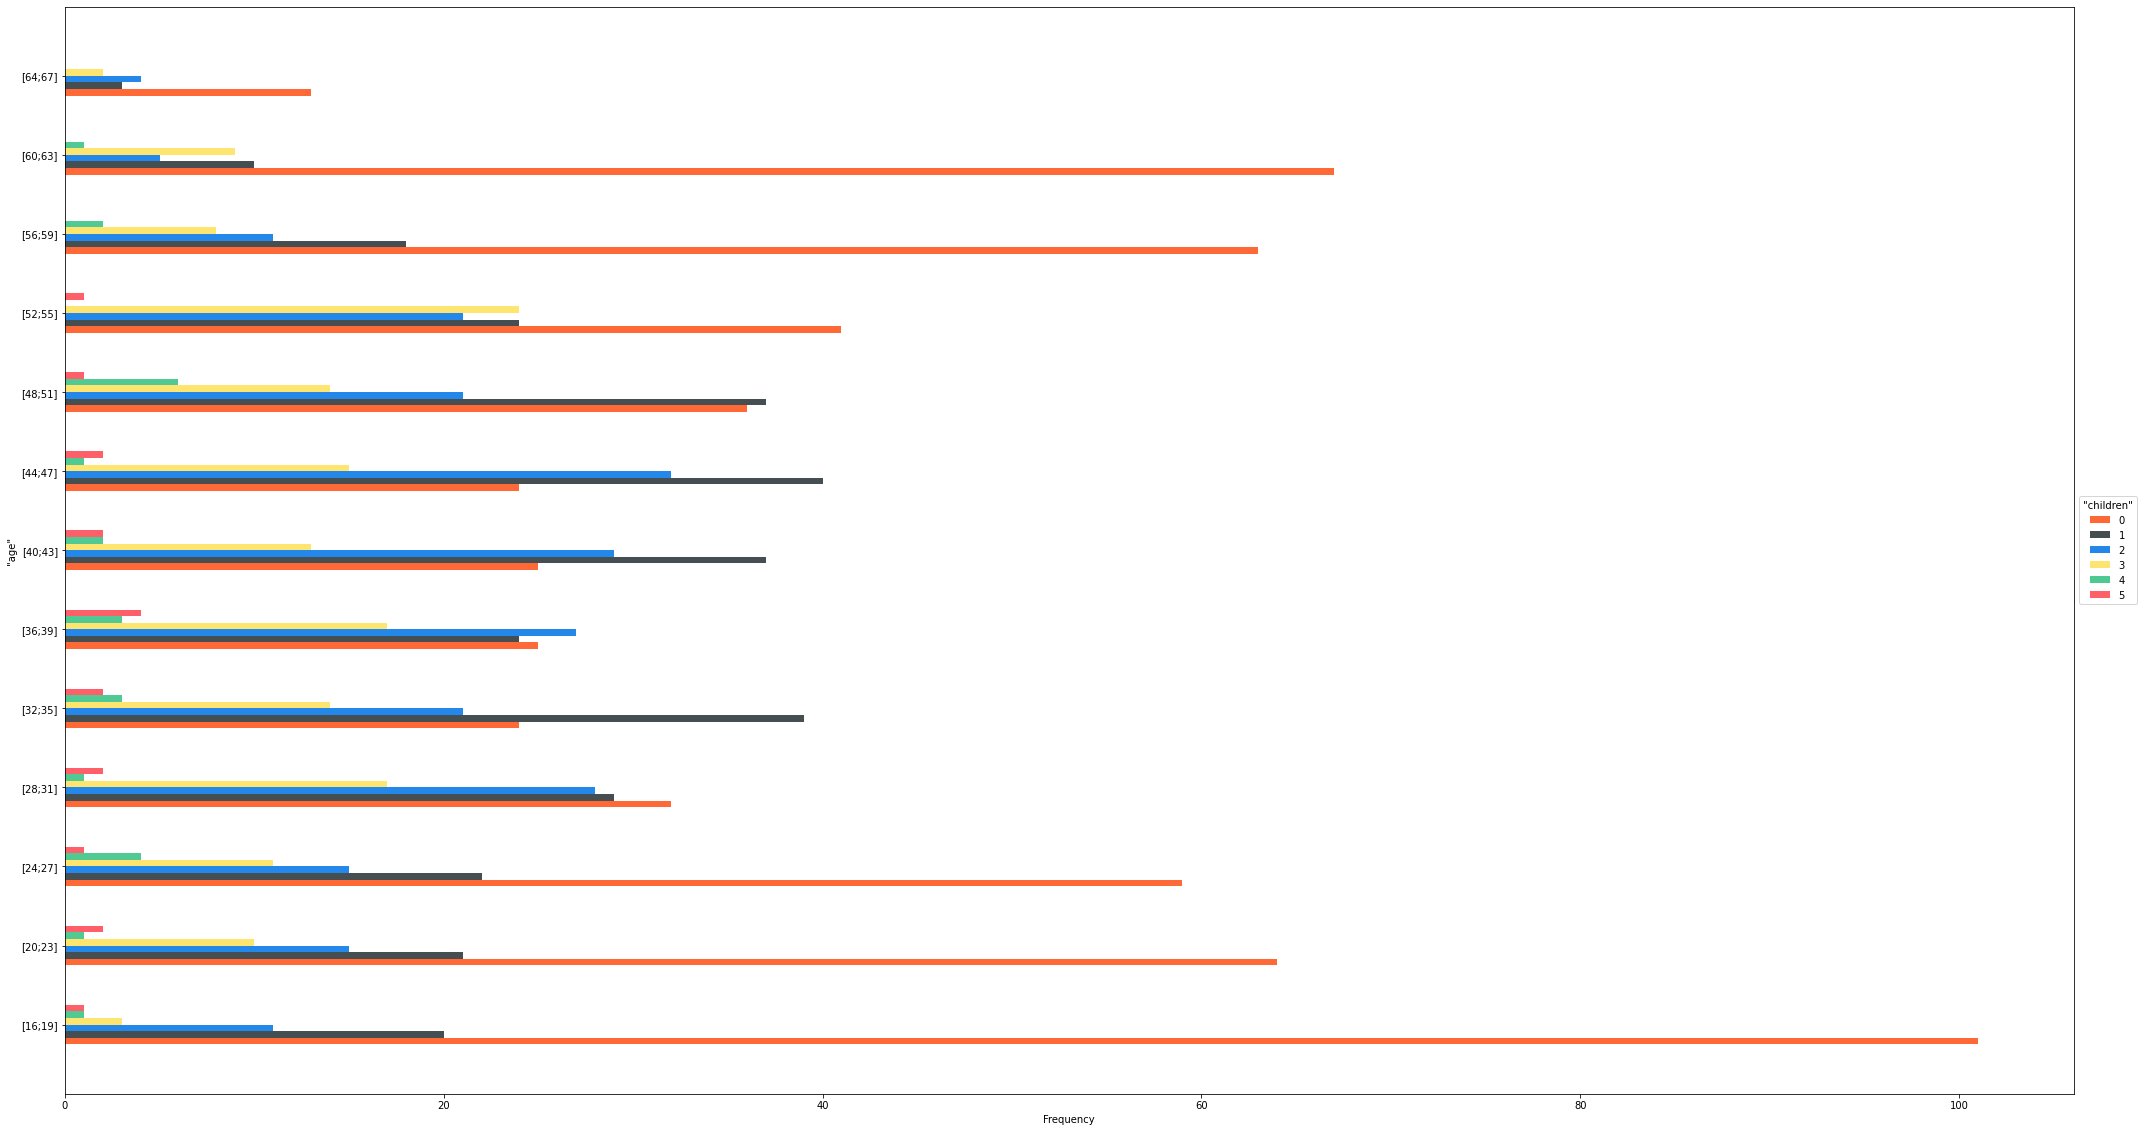

In [171]:
# distribution of age with respect to number of children
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(45, 20))
ax = insurance_data.bar(['age', 'children'],
                   method='count',
                       ax=axes)

* The number of people with no depending children are higher in early age and it decrease in middle age period then it increase in older age phase.

### Age 

In [88]:
# Distribution of the peoples's age
insurance_data.hchart(x="age",
                      kind="bar",
                      h=2,
                      height=400,
                      width=900)

* The young adults of 18 and 19 years old are significantly frequent comparing to all other ages, they are more than double frequent than every age. 

In [89]:
# Boxplot for charges with respect to age
insurance_data.hchart(x="charges",
                      y="age",
                      kind="boxplot",
                      height=500,
                      width=1000)

* It is clear that the trend of the average charges is increasing with respects to the age.

In [90]:
# Distribution of the peoples's age vs bmi
insurance_data.hchart(x="age",
                      y='age',
                      z='ROUND(AVG(bmi),1) AS Average_BMI',
                      kind="bar",
                      h=10,
                      aggregate=True,
                      height=250,
                      width=900)

* This graph shows that __BMI__ has increasing trend with respect to the age. We can interpret that by the lack of physical activities for older people, which leads to higher chance to health problems.

### BMI

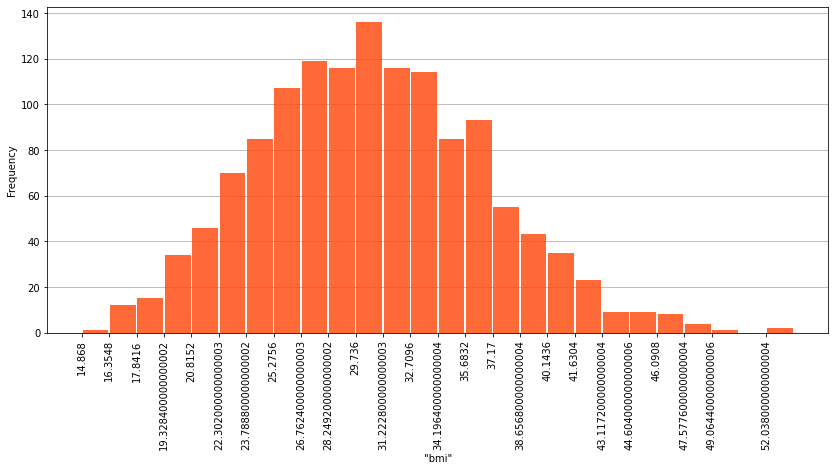

In [91]:
# Distribution of bmi
ax = insurance_data["bmi"].hist(method="count",
                                nbins=25,
                                h=5,
                                color='#FE5016')

The `bmi` has Gaussian distribution

We categorize the BMI to 4 category based on its value for more clarification:

|BMI|	Weight Status|
|---|----------------|
|Below 18.5	|Underweight|
|18.5—24.9	|Healthy|
|25.0—29.9	|Overweight|
|30.0 and Above	|Obese|


We will add a column `ws` that referring to weight status of each sample.

,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat,Abcsmoker_statusVarchar(11),Abcchildren_statusVarchar(12),AbcwsVarchar(11)
1,18,female,20.79,0,❌,southeast,1607.5101,none smoker,no children,Healthy
2,18,female,21.66,0,✅,northeast,14283.4594,smoker,no children,Healthy
3,18,female,24.09,1,❌,southeast,2201.0971,none smoker,has children,Healthy
4,18,female,25.08,0,❌,northeast,2196.4732,none smoker,no children,Overweight
5,18,female,26.315,0,❌,northeast,2198.18985,none smoker,no children,Overweight
6,18,female,26.73,0,❌,southeast,1615.7667,none smoker,no children,Overweight
7,18,female,27.28,3,✅,southeast,18223.4512,smoker,has children,Overweight
8,18,female,28.215,0,❌,northeast,2200.83085,none smoker,no children,Overweight
9,18,female,29.165,0,❌,northeast,7323.734819,none smoker,no children,Overweight
10,18,female,30.115,0,❌,northeast,2203.47185,none smoker,no children,Obese

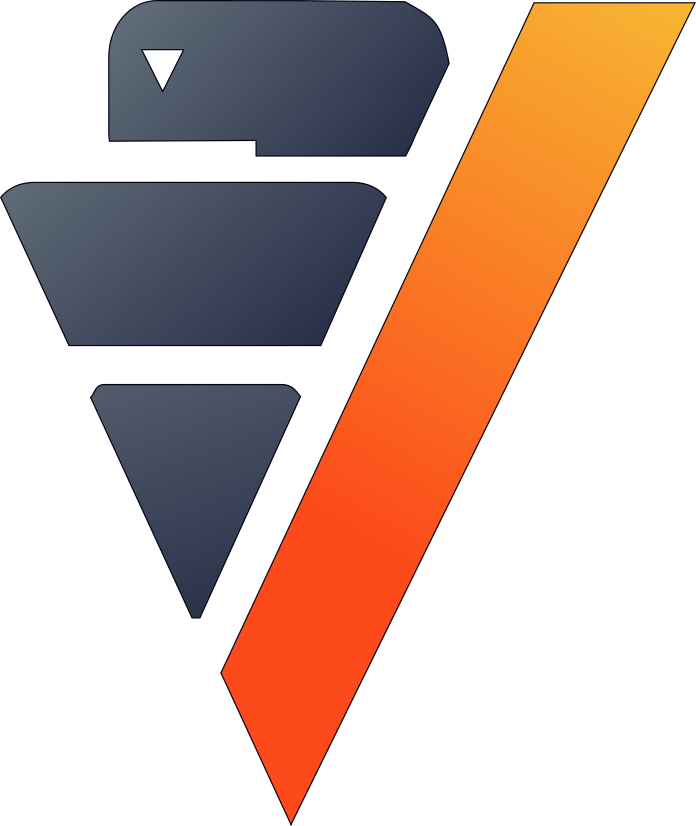

In [92]:
# Add a new feature Weight Status
insurance_data.case_when("ws",
                         insurance_data["bmi"] < 18.5, "Underweight",
                         insurance_data["bmi"] < 25, "Healthy",
                         insurance_data["bmi"] < 30, "Overweight",
                         "Obese")

In [93]:
# Add a new feature for visualization purpose
# insurance_data.drop(columns=['charges_cat'])
insurance_data.case_when("charges_cat",
                         insurance_data["charges"] <=31000 , "lower than 31k",
                         "above 31k")
# Scatter plot od the bmi vs charges
insurance_data.hchart(x="bmi",
                      y="charges",
                      c="charges_cat",
                      kind="scatter",
                      height=400,
                      width=900)

* We can see that the majority of the charges above the charges median __31k__ where charged on __obese__ people.

In [94]:
# distribution of the weight status 
insurance_data.hchart(x="ws",
                      y="ws",
                      z="COUNT(ws) AS Frequency",
                      kind="bar",
                      height=300,
                      width=800)

In [95]:
# Boxplot of charges w.r.t weight status
insurance_data.hchart(x="charges",
                      y="ws",
                      kind="boxplot",
                      height=300,
                      width=450)

In [96]:
# Average charges w.r.t to weights status
insurance_data.hchart(x="ws",
                      y="ws",
                      z="ROUND(AVG(charges)) As Avg_charges",
                      kind="bar",
                      height=300,
                      width=450)

* We can see that the persons categorized as `Obese` and `Overweight` representing __81.6%__ of the population. We can say that the population is suffering from overweight problem.
* Underweight people have the lowest charges compare to all the other categorize, and as expected the obese person are more likely to have health issues.

In [97]:
# Display the average score of bmi for every gender
insurance_data.hchart(x="sex",
                      y="sex",
                      z="ROUND(AVG(bmi),2) AS Avg_BMI",
                      kind="bar",
                      height=250,
                      width=850)

* The `bmi` average is almost the same for both genders 

In [98]:
# Display the distribution of bmi category with respect to every gender
insurance_data.hchart(x="ws",
                      y="sex",
                      z="COUNT(ws)",
                      kind="bar",
                      height=250,
                      width=450)

In [99]:
# distribution of average charges w.r.t weight status and gender
insurance_data.hchart(x="ws",
                      y="sex",
                      z="ROUND(AVG(charges)) AS Avg_charges",
                      kind="bar",
                      height=250,
                      width=450)

* We can observe __obese__ people have higher charges regardless of their gender.

### Region

In [100]:
# Plot the count population in every region
insurance_data.hchart(x="region",
                      kind="pie",
                      height=300,
                      width=500)

In [101]:
# Boxplot of charges by region
insurance_data.hchart(x="charges",
                      y="region",
                      kind = "boxplot",
                      height = 300,
                      width = 400)

* The distribution of the population on the four regions is uniform (24%-27%), and the charges range is almost equal.

In [102]:
# Display the average score of bmi for every region
insurance_data.hchart(x="region",
                      y="region",
                      z="ROUND(AVG(bmi),1) AS Average_BMI",
                      kind="bar",
                      height=300,
                      width=450)

In [103]:
# Display the average charges by the region
insurance_data.hchart(x="region",
                      y="region",
                      z="ROUND(AVG(charges)) AS Average_Charges",
                      kind="bar",
                      height=300,
                      width=450)

* We see that __southeast__ has the higher __BMI__ average and also has the higher average of charges.

In [104]:
# Average charges of each gender by the region
insurance_data.hchart(x="sex",
                      y="region",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=300,
                      width=900)

* Men are slightly more charged than women in 3 out of 4 regions 

In [105]:
# Smoker and none smoker by the region
insurance_data.hchart(x="smoker_status",
                      y="region",
                      z="COUNT(smoker_status)",
                      kind="bar",
                      height=300,
                      width=900)

* The distribution of smokers and none smoker almost the same in the 4 region


## Business objective

The standard way in this case is build a model to predict the charges of the customers, but there is a disadvantage of that, which is the error gap between the ground truth and the prediction. For instance, the error representing 5% of the true amount is acceptable, but what about if the error is more than 25%, 50%, or even 75%? How this will affect the business?
To over come this, I suggested to use insurance plans instead of charge amount. Building a model to predict the best (optimize) plan for the costumer with respect of its situation is better and less risky. The the question will be:

### What is the best insurance tier for every customer?


In the united states the average monthly national cost for health insurance will be $456. However, charges vary across a wide range of health insurance. 

Understanding the link between health coverage and cost might assist us in selecting the most appropriate health insurance for every customer.

There are 4 different insurance health plans offered:


|Tiers|Bronze|Silver|Gold|Platinum|
|-----|-----|-----|-----|------|
|You pay|40\% |30\%|20\%|10\%|
|Insurance pays|60\% |70\%|80\%|90\%|

The insurance cost depends on the chosen tier:

__For individuals:__

|Tiers|Bronze|Silver|Gold|Platinum|
|-----|-----|-----|-----|------|
|Cost (\$) per month|448 |483|569|732|
|Cost (\$) per year|5376 |5796|6828|8784|



__For families:__

|Tiers|Bronze|Silver|Gold|Platinum|
|-----|-----|-----|-----|------|
|Cost (\$) per month|1041 |1212|1437|1610|
|Cost (\$) per year|12492 |14544|17244|19320|



Source [link](https://www.ehealthinsurance.com/resources/individual-and-family/how-much-does-individual-health-insurance-cost#:~:text=In%202020%2C%20the%20average%20national,wide%20selection%20of%20health%20plans.)


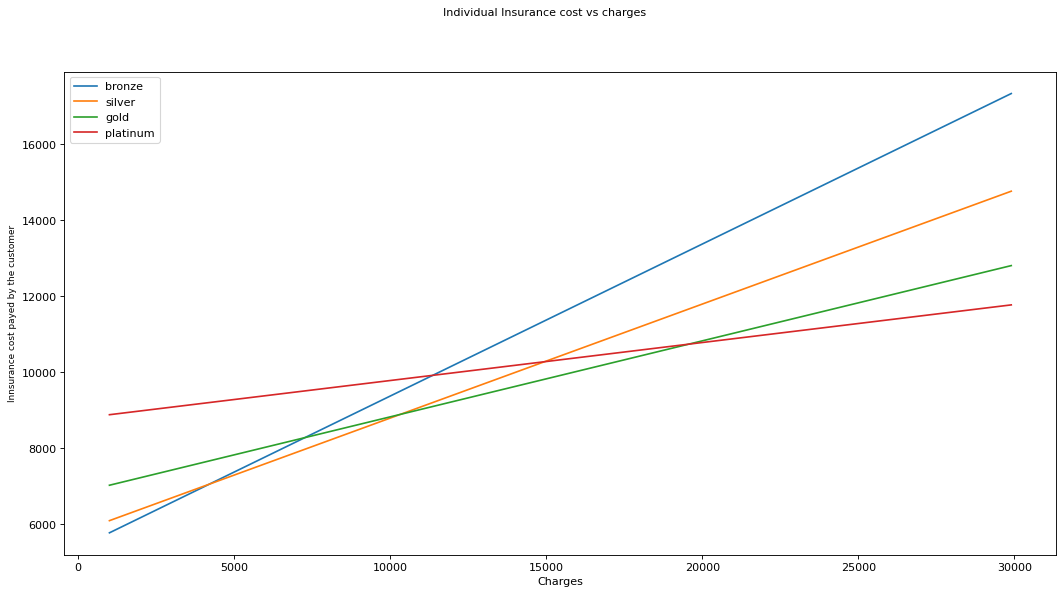

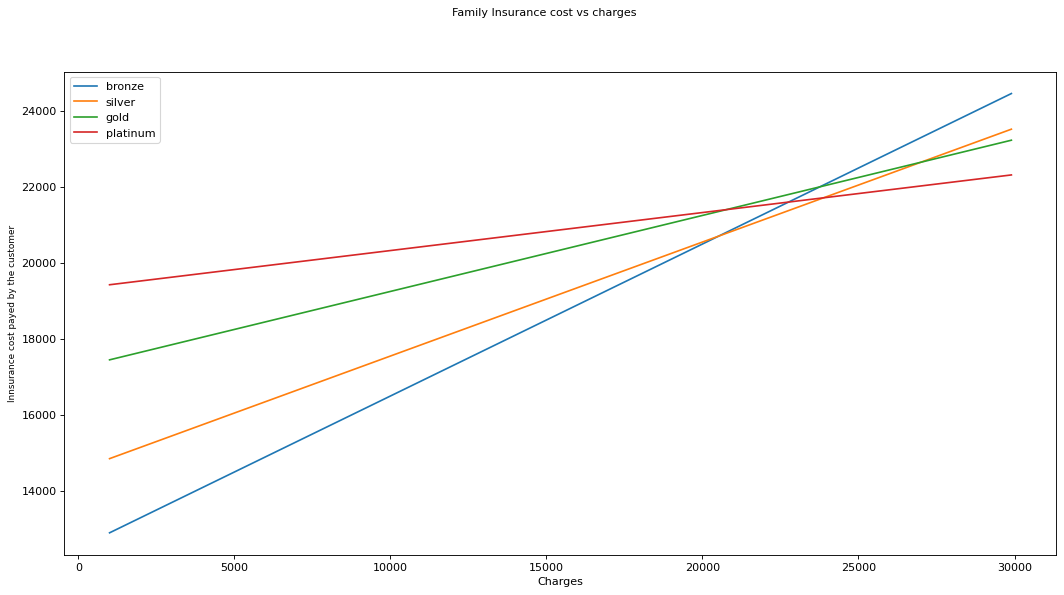

In [106]:
# plot the equations of 
figure(figsize=(16, 8), dpi=80)

ind_plans = {'bronze': [5376, 0.4], 'silver': [5796, 0.3], 
             'gold': [6828, 0.2], 'platinum': [8784, 0.1]}
family_plans = {'bronze': [12492, 0.4], 'silver': [14544, 0.3], 
                'gold': [17244, 0.2], 'platinum': [19320, 0.1]}

medical_cost_range = range(1000, 30000, 100)

bronze_cost = [ind_plans['bronze'][0]+x*ind_plans['bronze'][1]
               for x in medical_cost_range]
silver_cost = [ind_plans['silver'][0]+x*ind_plans['silver'][1]
               for x in medical_cost_range]
gold_cost = [ind_plans['gold'][0]+x*ind_plans['gold'][1]
             for x in medical_cost_range]
platinum_cost = [ind_plans['platinum'][0]+x*ind_plans['platinum'][1]
                 for x in medical_cost_range]

plt.plot(medical_cost_range, bronze_cost, label='bronze')
plt.plot(medical_cost_range, silver_cost, label='silver')
plt.plot(medical_cost_range, gold_cost, label='gold')
plt.plot(medical_cost_range, platinum_cost, label='platinum')
plt.legend()
plt.suptitle('Individual Insurance cost vs charges', fontsize=10)
plt.xlabel('Charges', fontsize=10)
plt.ylabel('Innsurance cost payed by the customer', fontsize=8)
plt.show()


figure(figsize=(16, 8), dpi=80)
bronze_cost = [family_plans['bronze'][0]+x*family_plans['bronze'][1]
               for x in medical_cost_range]
silver_cost = [family_plans['silver'][0]+x*family_plans['silver'][1]
               for x in medical_cost_range]
gold_cost = [family_plans['gold'][0]+x*family_plans['gold'][1]
             for x in medical_cost_range]
platinum_cost = [family_plans['platinum'][0]+x *
                 family_plans['platinum'][1] for x in medical_cost_range]

plt.plot(medical_cost_range, bronze_cost, label='bronze')
plt.plot(medical_cost_range, silver_cost, label='silver')
plt.plot(medical_cost_range, gold_cost, label='gold')
plt.plot(medical_cost_range, platinum_cost, label='platinum')
plt.legend()
plt.suptitle('Family Insurance cost vs charges', fontsize=10)
plt.xlabel('Charges', fontsize=10)
plt.ylabel('Innsurance cost payed by the customer', fontsize=8)
plt.show()

## Feature Engineering

,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat,Abcsmoker_statusVarchar(11),Abcchildren_statusVarchar(12),AbcwsVarchar(11),Abccharges_catVarchar(14),Abcinsurance_planVarchar(8)
1,18,female,20.79,0,❌,southeast,1607.5101,none smoker,no children,Healthy,lower than 31k,bronze
2,18,female,21.66,0,✅,northeast,14283.4594,smoker,no children,Healthy,lower than 31k,gold
3,18,female,24.09,1,❌,southeast,2201.0971,none smoker,has children,Healthy,lower than 31k,bronze
4,18,female,25.08,0,❌,northeast,2196.4732,none smoker,no children,Overweight,lower than 31k,bronze
5,18,female,26.315,0,❌,northeast,2198.18985,none smoker,no children,Overweight,lower than 31k,bronze
6,18,female,26.73,0,❌,southeast,1615.7667,none smoker,no children,Overweight,lower than 31k,bronze
7,18,female,27.28,3,✅,southeast,18223.4512,smoker,has children,Overweight,lower than 31k,bronze
8,18,female,28.215,0,❌,northeast,2200.83085,none smoker,no children,Overweight,lower than 31k,bronze
9,18,female,29.165,0,❌,northeast,7323.734819,none smoker,no children,Overweight,lower than 31k,silver
10,18,female,30.115,0,❌,northeast,2203.47185,none smoker,no children,Obese,lower than 31k,bronze

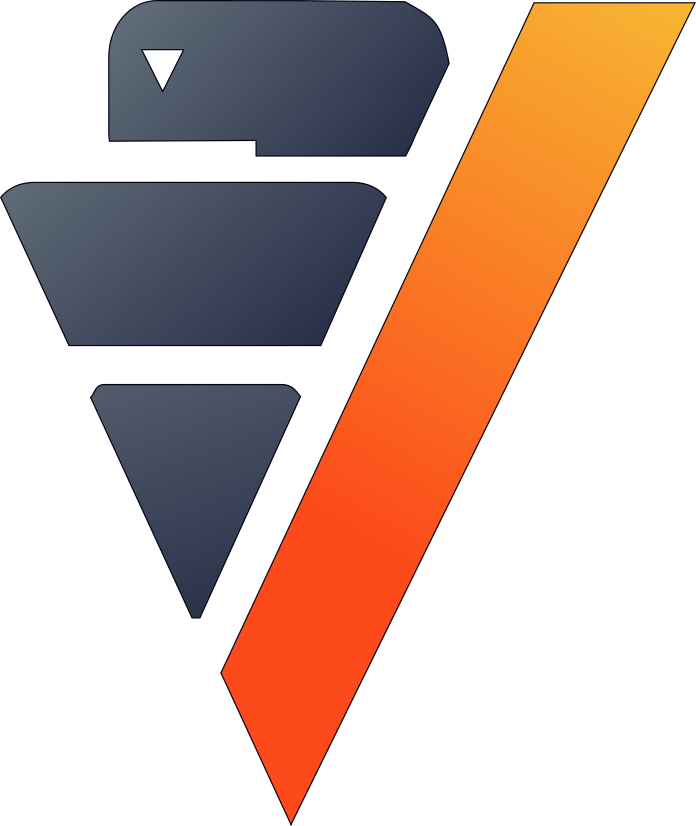

In [107]:
# add insurance_plan column reprenting the best insurance plan for every sample
sql_query = """CASE WHEN charges<=5000 AND children =0 THEN 'bronze' 
                    WHEN charges<=20000 AND children <>0 THEN 'bronze' 
                    WHEN charges<=10000 AND children =0 THEN 'silver' 
                    WHEN charges<=48000 AND children <>0 THEN 'silver' 
                    WHEN charges>20000 AND children =0 THEN 'platinum' 
                    WHEN charges>48000 AND children <>0 THEN 'platinum' 
                    ELSE 'gold' END"""
insurance_data.eval(name="insurance_plan",
                    expr=sql_query)

In [125]:
# Add a new feature Weight Status
insurance_data.hchart(x="insurance_plan",
                      kind="bar",
                      height=250,
                      width=900)

The classes are not balanced, the `bronze` represented by __60%__ of the samples, `silver` by __18%__, `gold` by __13%__, and `platinum` by __9%__ 

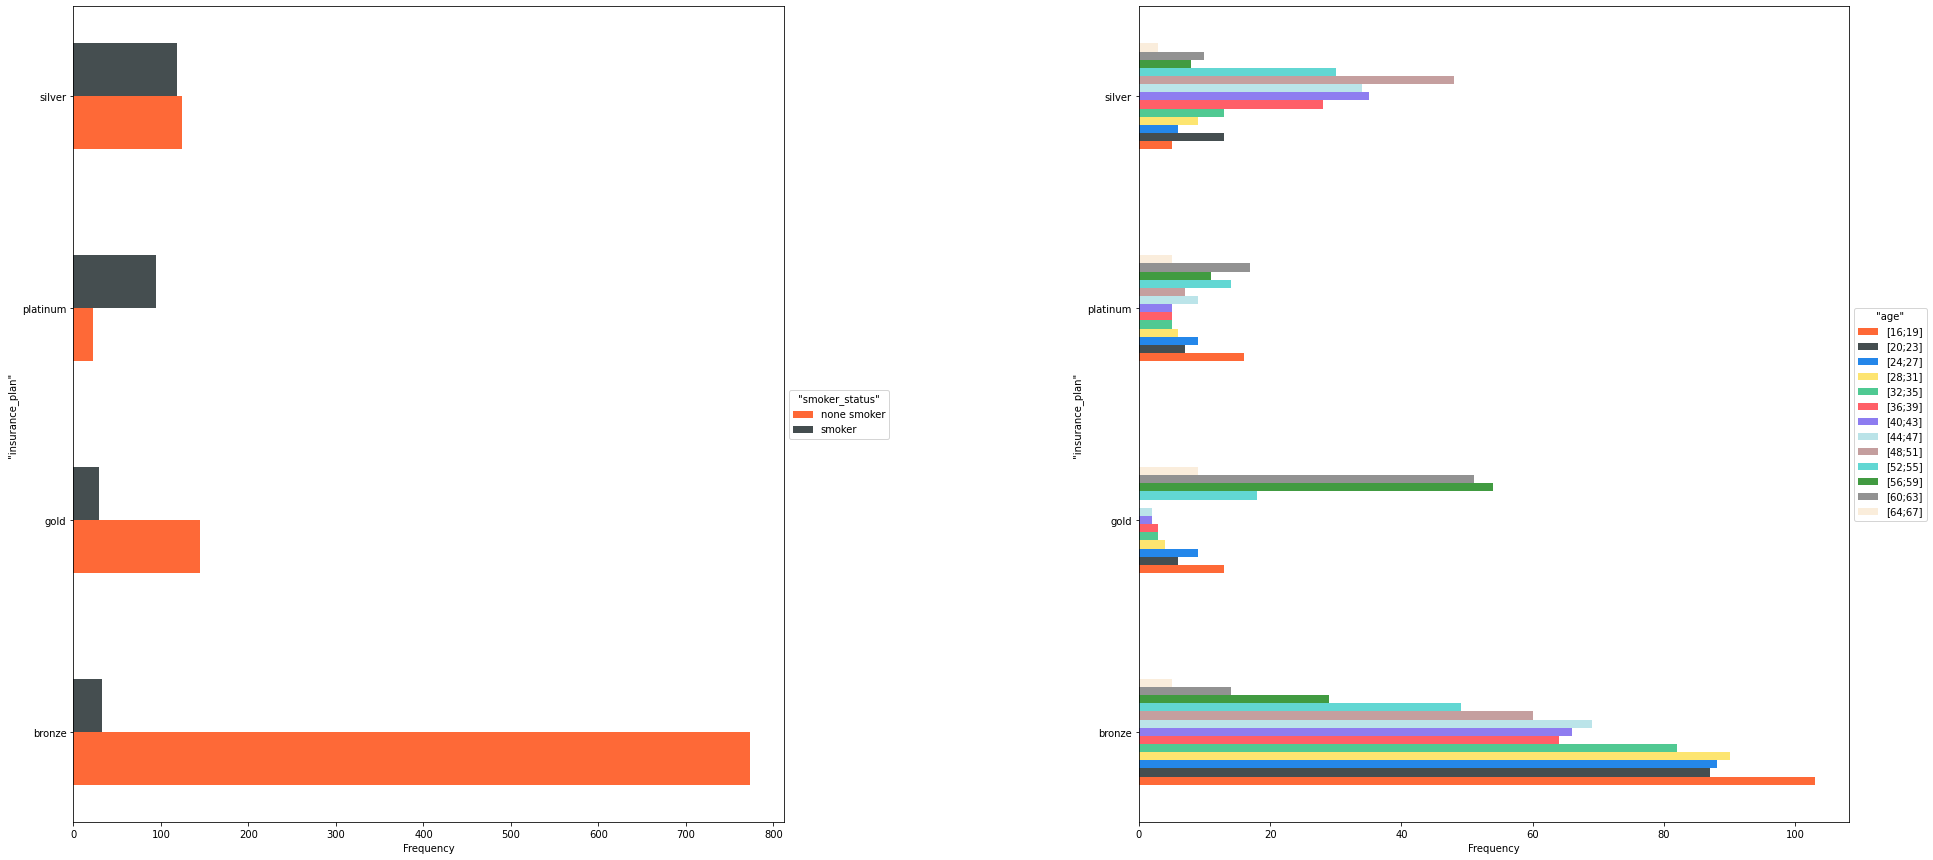

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))
# distribution of smoking status w.r.t insurance plan
ax = insurance_data.bar(["insurance_plan", "smoker_status"],
                   method='count',
                   ax=axes[0])
# distribution of age w.r.t insurance plan
ax = insurance_data.bar(["insurance_plan", "age"],
                   method='count',
                   ax=axes[1])

* The majority of none smoker are within the bronze tier, the number of smokers in platinum tier is much higher compare to none smokers. The conclusion is the same as before: the smoking leads to health issue which leads to higher charges that requires expensive tier health insurance.

* The majority of young people are in bronze tier, we can say because it's normal that young adults have less chances to have health issues


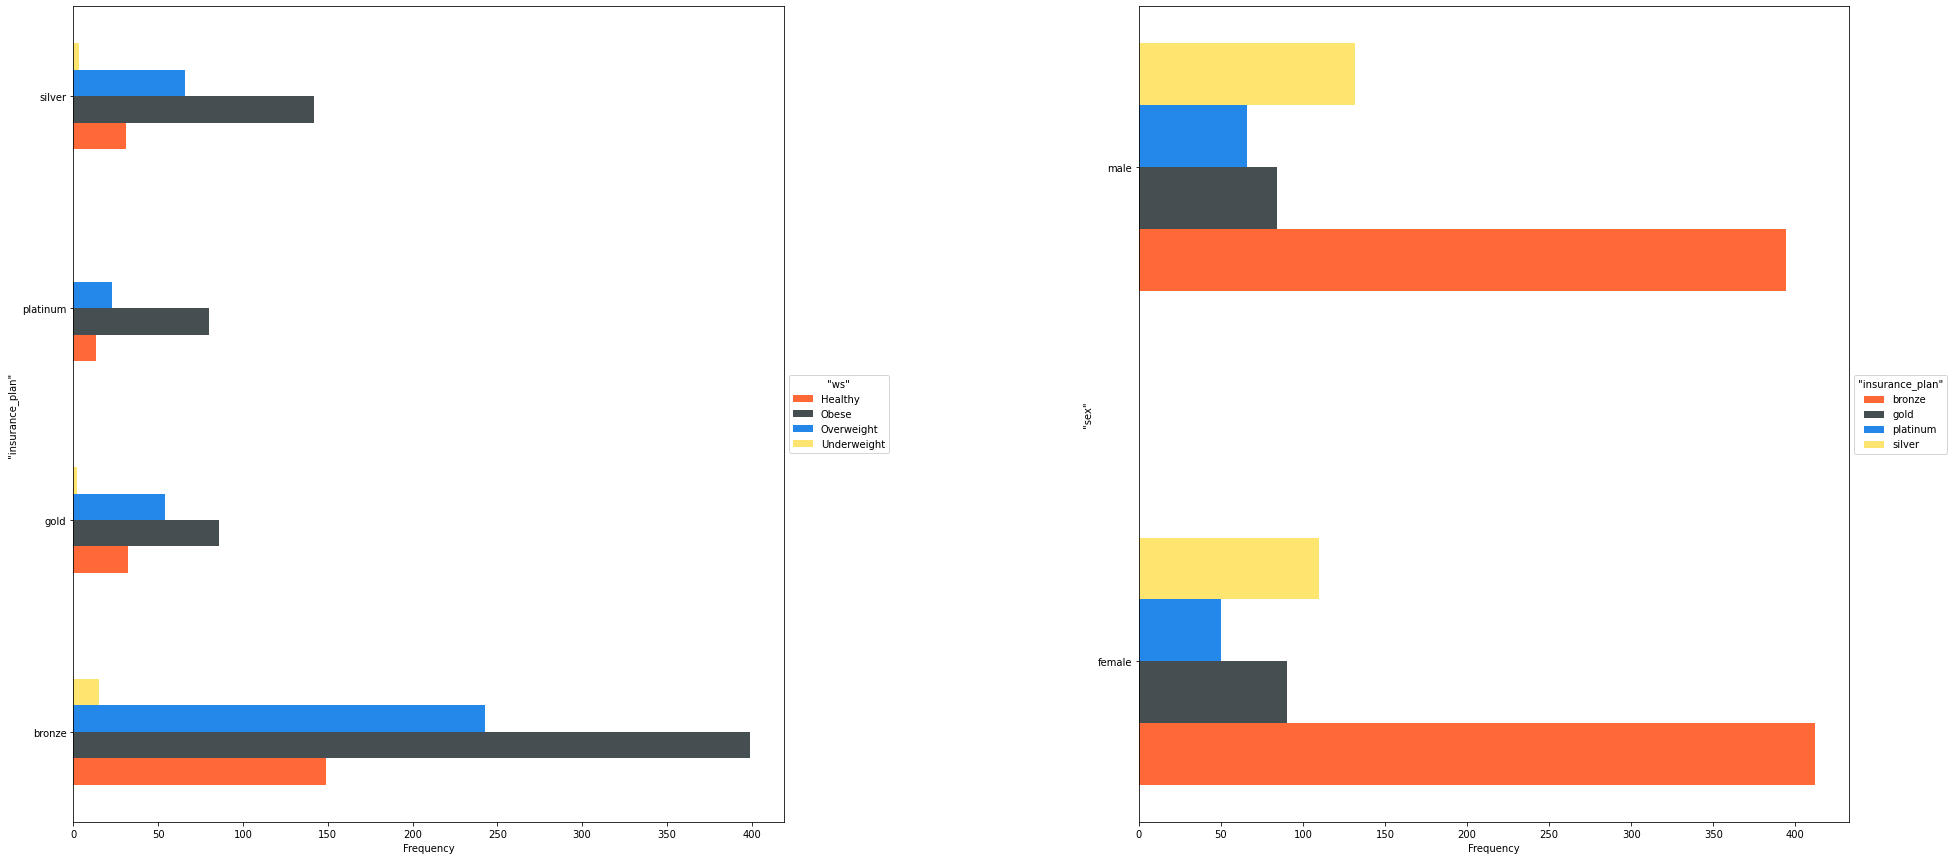

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))
# distribution of weight status w.r.t insurance plan
ax = insurance_data.bar(["insurance_plan","ws"],
                       method='count',
                       ax=axes[0])
# distribution of sex w.r.t insurance plan
ax = insurance_data.bar(["sex", "insurance_plan"],
                       method='count',
                       ax=axes[1])

* The obese people have the higher proportion in all type of insurance tier, due to the higher chance to have medical issues due to severe overweight.
* The healthy people are more in bronze tier than other tiers. 
* The gender does not have that impact on the tier plan. The distribution almost the same for men and women 

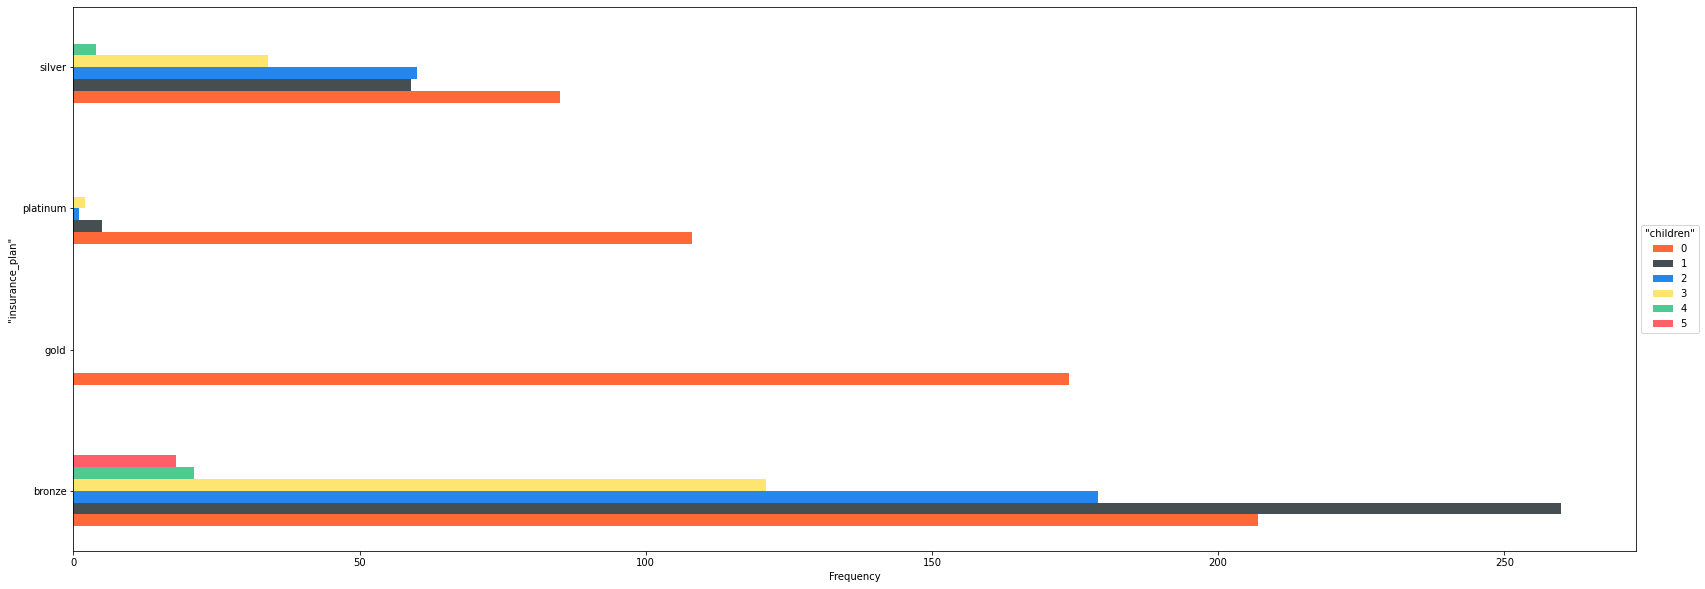

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(35, 10))
# distribution of children w.r.t insurance plan
ax = insurance_data.bar(["insurance_plan","children" ],
                       method='count',
                       ax=axes)

* Almost all the parents with dependent children are spread on bronze and silver tiers, the rest in platinum tier. 

### Correlation 

,"""age""","""bmi""","""children"""
"""age""",1.0,0.107283138750997,0.0589888917583676
"""bmi""",0.107283138750997,1.0,0.0151009719083005
"""children""",0.0589888917583676,0.0151009719083005,1.0

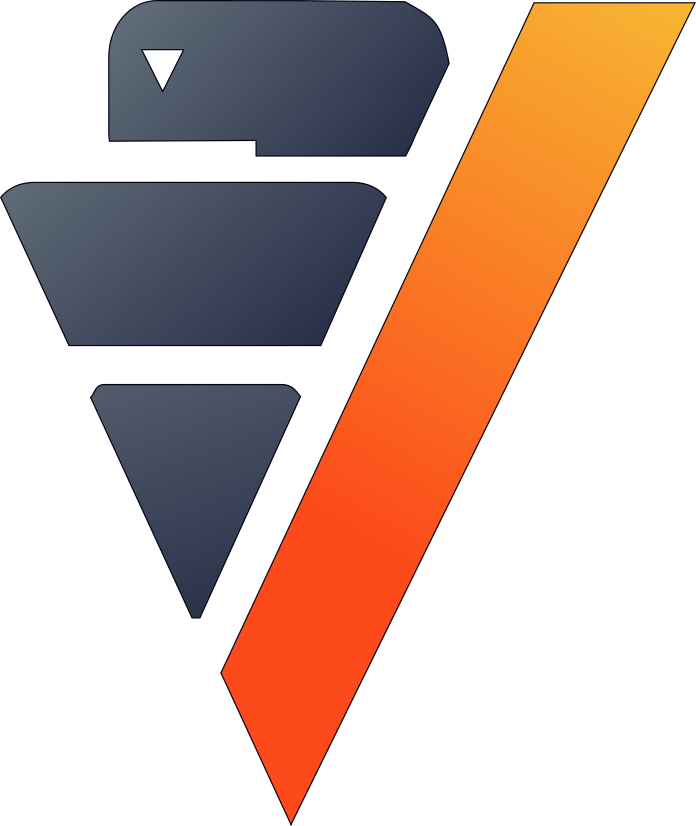

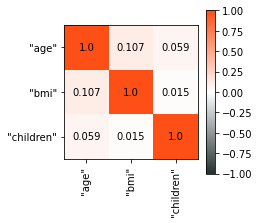

In [44]:
# select numerical and categorical features
num_selected_columns = ["age",  "bmi", "children"]
cat_selected_columns = ["sex", "smoker_status", "region"]
# correlation matrix for numerical features
insurance_data.corr(num_selected_columns, method="spearman")

  0%|          | 0/2 [00:00<?, ?it/s]

,"""sex""","""smoker_status""","""region"""
"""sex""",1,0.07618481692109515,0.018033700256745108
"""smoker_status""",0.07618481692109515,1,0.07408372915032316
"""region""",0.018033700256745108,0.07408372915032316,1

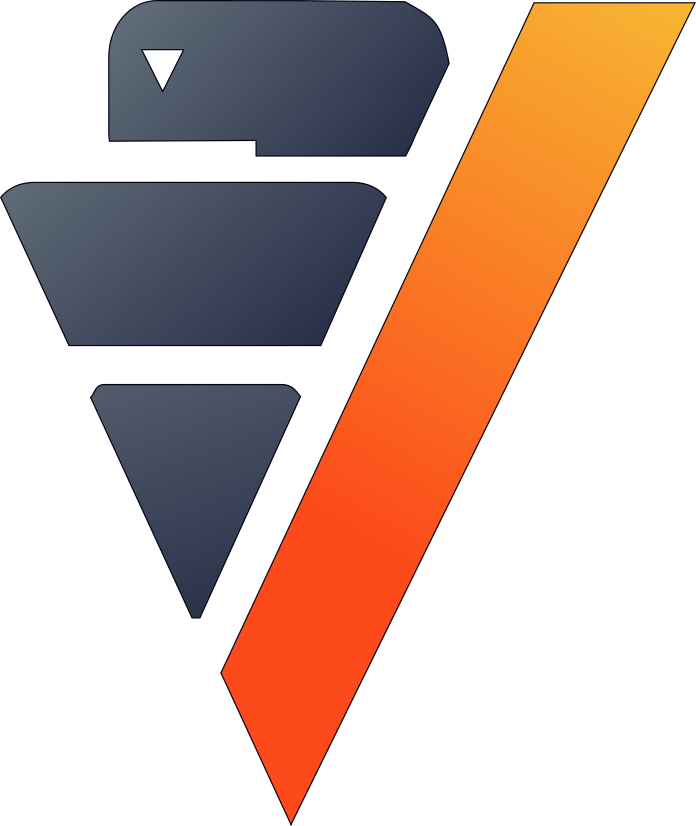

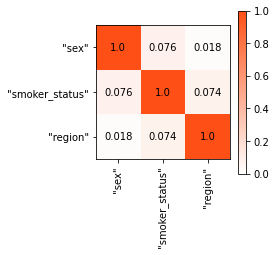

In [45]:
# correlation matrix for categorical features
insurance_data.corr(cat_selected_columns, method="cramer")

### Machine Learning

We will use assembly methods based on decision trees and Naive Bayes models because they can deal with categorical features and it is not get affect by the outliers if they exist, and also it doesn't need any scaling for numerical features.

In [46]:
# save our modified dataset to the database
# insurance_data.to_db("insurance.final_insurance_data_clas", relation_type = "table")
# insurance_data = insurance_data.balance(column = "insurance_plan", method = "hybrid")
# split data to train and test sudsets
train_data, test_data = insurance_data.train_test_split(test_size=0.3,
                                                        random_state=42)

In [47]:
# save the subsets in database
# vp.drop("final_train_insurance_data_clas", relation_type="table")
# vp.drop("final_test_insurance_data_clas", relation_type="table")
# train_data.to_db("final_train_insurance_data_clas", relation_type="table")
# test_data.to_db("final_test_insurance_data_clas", relation_type="table")

In [48]:
# define the random forest model
rf_model = RandomForestClassifier(name="insurance.randf_model_insurance",
                                             n_estimators=25,
                                             max_features="auto",
                                             max_leaf_nodes=70,
                                             sample=1.0,
                                             max_depth=6,
                                             min_samples_leaf=2,
                                             min_info_gain=0.0,
                                             nbins=32)
# selected features
predictors = ['sex', 'smoker_status', 'region', 'bmi', 'age', 'children']
target = "insurance_plan"
# train the model
rf_model.fit(train_data,
                        predictors,
                        target)



call_string
SELECT rf_classifier('insurance.randf_model_insurance', '"insurance"."_verticapy_tmp_view_dbadmin_36819_8346141717_"', 'insurance_plan', '"sex", "smoker_status", "region", "bmi", "age", "children"' USING PARAMETERS exclude_columns='', ntree=25, mtry=3, sampling_size=1, max_depth=6, max_breadth=70, min_leaf_size=2, min_info_gain=0, nbins=32);

details
  predictor  |      type      
-------------+----------------
     sex     |char or varchar 
smoker_status|char or varchar 
   region    |char or varchar 
     bmi     |float or numeric
     age     |      int       
  children   |      int       


Additional Info
       Name       |Value
------------------+-----
    tree_count    | 25  
rejected_row_count| 229 
accepted_row_count| 707 

,importance,sign
age,35.15,1
children,27.95,1
smoker_status,25.17,1
bmi,9.58,1
region,1.74,1
sex,0.42,1

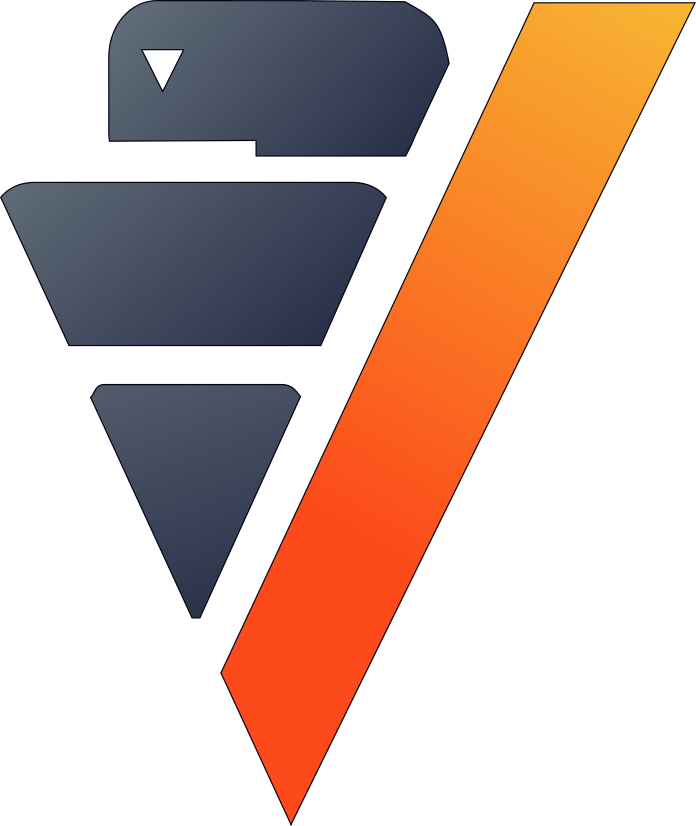

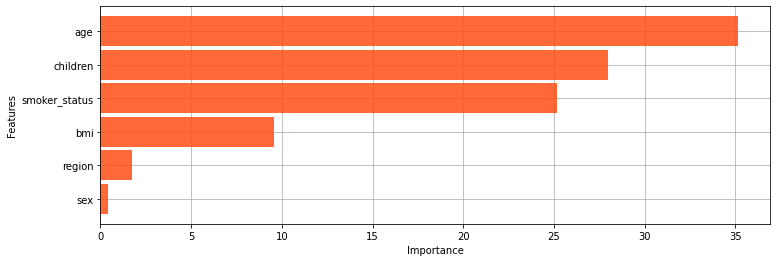

In [49]:
# feature importance for our random forest model
rf_model.features_importance()

The most important features are: `age`,`children`, `smoker_status`, `bmi`.

The age of the customer have great impact on the type of insurance tier, then come the number of children, smoking status, and BMI

In [50]:
# XGBoost model definition
xgb_model = XGBoostClassifier(name="insurance.xgb_model_insurance",
                              max_ntree=20,
                              max_depth=6,
                              nbins=32,
                              split_proposal_method="global",
                              tol=0.001,
                              learning_rate=0.1,
                              min_split_loss=0.0,
                              weight_reg=0.0,
                              sample=1.0,
                              col_sample_by_tree=1.0,
                              col_sample_by_node=1.0,)


# fit XGBoost model
xgb_model.fit(train_data,
              predictors,
              target)



call_string
xgb_classifier('insurance.xgb_model_insurance', '"insurance"."_verticapy_tmp_view_dbadmin_36819_2504882564_"', '"insurance_plan"', '"sex", "smoker_status", "region", "bmi", "age", "children"' USING PARAMETERS exclude_columns='', max_ntree=20, max_depth=6, learning_rate=0.1, min_split_loss=0, weight_reg=0, nbins=32, objective=crossentropy, sampling_size=1, col_sample_by_tree=1, col_sample_by_node=1)

details
  predictor  |      type      
-------------+----------------
     sex     |char or varchar 
smoker_status|char or varchar 
   region    |char or varchar 
     bmi     |float or numeric
     age     |      int       
  children   |      int       


initial_prediction
response_label| value  
--------------+--------
    bronze    | 0.00000
     gold     | 0.00000
   platinum   | 0.00000
    silver    | 0.00000


Additional Info
       Name       |Value
------------------+-----
    tree_count    | 20  
rejected_row_count| 229 
accepted_row_count| 707 

In [154]:
from verticapy.learn.naive_bayes import NaiveBayes
nb_model = NaiveBayes(name = "insurance.nb_model_insurance", 
                      alpha = 1.0)

# fit NaiveBayes model
nb_model.fit(train_data,
              predictors,
              target)



details
index|  predictor   |   type    
-----+--------------+-----------
  0  |insurance_plan| ResponseC 
  1  |     sex      |Categorical
  2  |smoker_status |Categorical
  3  |    region    |Categorical
  4  |     bmi      | Gaussian  
  5  |     age      |Multinomial
  6  |   children   |Multinomial


=====
prior
=====
 class  |probability
--------+-----------
 bronze |  0.59722  
  gold  |  0.12500  
platinum|  0.08761  
 silver |  0.19017  


call_string
naive_bayes('insurance.nb_model_insurance', '"insurance"."_verticapy_tmp_view_dbadmin_41737_5220278363_"', '"insurance_plan"', '"sex", "smoker_status", "region", "bmi", "age", "children"' USING PARAMETERS exclude_columns='', alpha=1)

gaussian.bronze
index|   mu   |sigma_sq
-----+--------+--------
  4  |29.97013|38.38310


gaussian.gold
index|   mu   |sigma_sq
-----+--------+--------
  4  |30.27274|33.05835


gaussian.platinum
index|   mu   |sigma_sq
-----+--------+--------
  4  |32.05787|28.42422


gaussian.silver
index|   mu 

,bronze,gold,platinum,silver
auc,0.9791689403681264,0.9777558623712478,0.9618366938938707,0.9628198096706267
prc_auc,0.9818797586154442,0.9276891114757317,0.9040937385708051,0.9182304574058174
accuracy,0.9540598290598291,0.9636752136752137,0.969017094017094,0.9358974358974359
log_loss,0.0744225178591137,0.0453161712621202,0.042069561650586,0.0777239104649409
precision,0.9372881355932203,0.8074074074074075,0.7912087912087912,0.8105263157894737
recall,0.9892665474060823,0.9316239316239316,0.8780487804878049,0.8651685393258427
f1_score,0.9625761531766753,0.8650793650793651,0.8323699421965318,0.8369565217391305
mcc,0.9054205109577721,0.8471012557867972,0.8166940010393362,0.7977727199582433
informedness,0.8911233113318118,0.8998778998778998,0.8558005369280859,0.8176751356319114
markedness,0.9199470951307926,0.7974198918019142,0.779374471682164,0.7783547340200365

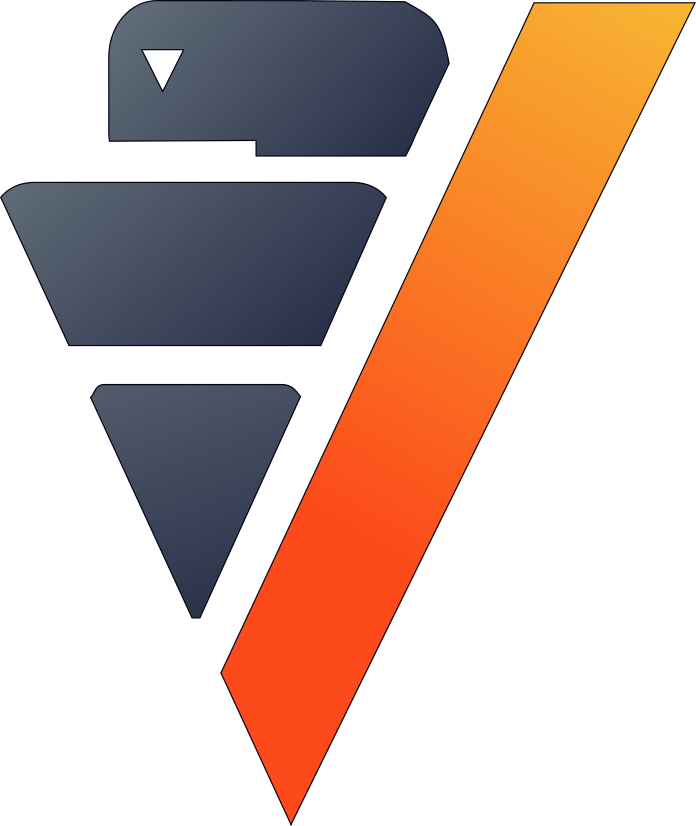

In [51]:
# classification report for Random Forest model
rf_model.report()

,bronze,gold,platinum,silver
auc,0.9726847392321457,0.9892040533066172,0.9682412749186038,0.9679115650292016
prc_auc,0.9675470293044788,0.9411518791362175,0.916755238785043,0.8957201361822767
accuracy,0.9572649572649573,0.9401709401709402,0.938034188034188,0.9487179487179487
log_loss,0.10001334251501,0.0605033130721017,0.0561443003329033,0.0860085807070847
precision,0.9435897435897436,0.6848484848484848,0.59375,0.8571428571428571
recall,0.9874776386404294,0.9658119658119658,0.926829268292683,0.8764044943820225
f1_score,0.965034965034965,0.8014184397163121,0.7238095238095238,0.8666666666666666
mcc,0.9117185817971354,0.7831162885819243,0.7125456053132598,0.8350044962639896
informedness,0.8999444821417555,0.9023199023199022,0.8659393385502943,0.8421037028252942
markedness,0.9236467236467236,0.679660417403608,0.5863242574257426,0.827965138309966

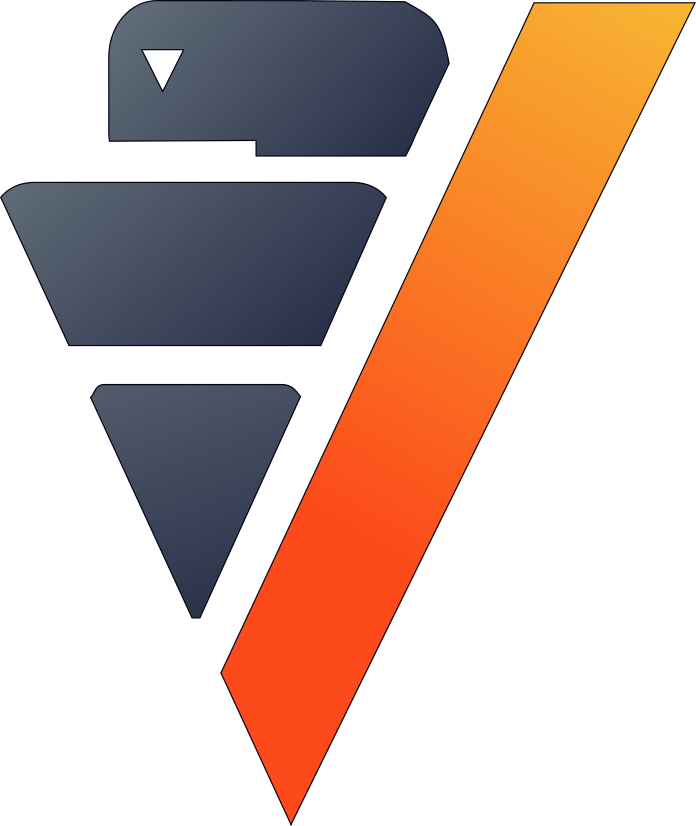

In [52]:
# classification report for XGBoost model
xgb_model.report()

,bronze,gold,platinum,silver
auc,0.9428474492628455,0.9299907120419929,0.9381747301079565,0.7143725356497009
prc_auc,0.9447689560993898,0.7492463891324563,0.7845610242443058,0.5553098851168737
accuracy,0.9326923076923077,0.8995726495726496,0.969017094017094,0.875
log_loss,0.150079343189578,0.094421272342015,0.0647873824390319,0.170998619597269
precision,0.9261168384879725,0.5761589403973509,0.8840579710144928,0.7798165137614679
recall,0.964221824686941,0.7435897435897436,0.7439024390243902,0.47752808988764045
f1_score,0.9447852760736196,0.6492537313432835,0.8079470198675496,0.5923344947735192
mcc,0.8598365367430267,0.5983071326299394,0.7947199557456965,0.5454849610481245
informedness,0.8501634692492752,0.6654456654456653,0.7345347575255612,0.4458658207583528
markedness,0.8696196633467297,0.5379423798877969,0.8598365177272955,0.6673618583805729

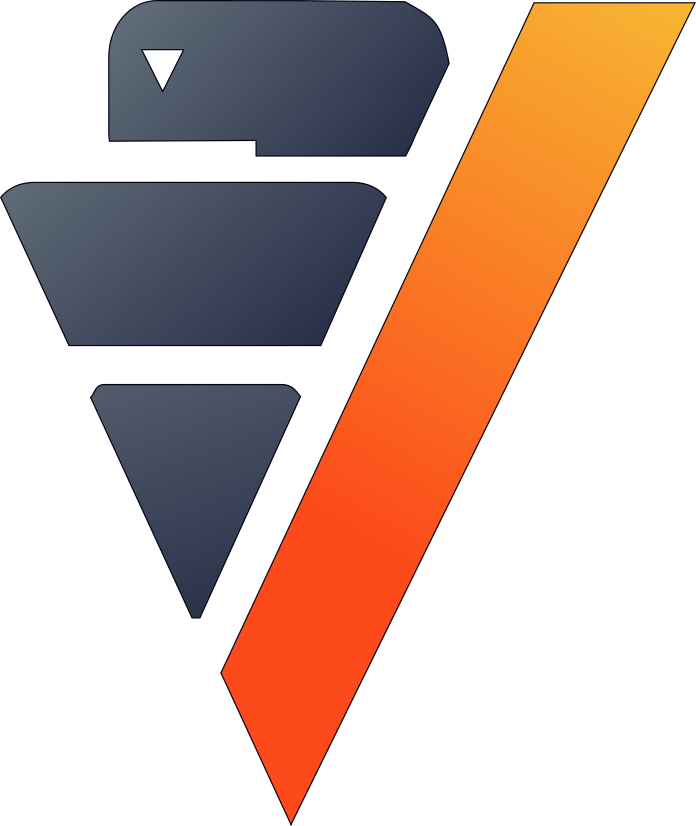

In [155]:
# classification report for NaiveBayes model
nb_model.report()

### Evaluation on test data


In [53]:
def kappa_score(confusion_mat):
    """
    This function compute the kappa score of the prediction using quadratic weigths and
    return a float:
                    0.01–0.20 as none to slight 
                    0.21–0.40 as fair 
                    0.41– 0.60 as moderate
                    0.61–0.80 as substantial
                    0.81–1.00 as almost perfect agreement

    Args:
        confusion_mat (2d numpy matrix ): confusion matrix of the ground truth and predictions

    Returns:
        float: kappa score between 0 and 1 
    """

    # number of samples
    n_samples = confusion_mat.sum()
    # observed agreement
    observed_mat = confusion_mat/n_samples

    # probs of each class w.r.t truth
    actual_prob = confusion_mat.sum(axis=1)/n_samples
    # probs of each class w.r.t prediction
    pred_prob = confusion_mat.sum(axis=0)/n_samples
    # matrix prob by chance agreement
    prob_bychance = np.outer(actual_prob, pred_prob)

    N = confusion_mat.shape[0]
    # weights matrix (distance)
    weights_mat = np.zeros((N, N))
    for i in range(len(weights_mat)):
        for j in range(len(weights_mat)):
            weights_mat[i][j] = 1 - float(((i-j)**2)/(N-1)**2)

    # prob of agreement
    agreement_prob = np.multiply(observed_mat, weights_mat).sum()
    # prob of by chance agreement
    bychance_agreement_prob = np.multiply(prob_bychance, weights_mat).sum()
    # compute kappa score
    kappa_score = (agreement_prob - bychance_agreement_prob) / \
        (1-bychance_agreement_prob)

    return kappa_score

In [54]:
def evaluation_report(model, test_data=test_data, predictors=predictors, 
                      prediction_label='prediction', target='insurance_plan'):
    """
    This function display a report of the prediction on test dataset:
        - Recall, Precision, and F1-Score for each class
        - Accuracy   
        - Marco-Recall    
        - Marco-Precision      
        - Macro-F1             
        - Weighted-F1          
        - Kappa Score (Quadratic weigths) 

    Args:
        model (_type_): pretrained model (estomator)
        test_data (vDataFrame, optional): test data. Defaults to test_data.
        predictors (list, optional): list of slected features. Defaults to predictors.
        prediction_label (str, optional): prediction column name. Defaults to 'prediction'.
        target (str, optional): target label. Defaults to 'insurance_plan'.
    """

    # labels
    labels = ['bronze', 'silver', 'gold', 'platinum']
    n_labels = len(labels)
    # prediction
    model.predict(test_data,
                  X=predictors,
                  name=prediction_label)

    # confusion matrix
    confusion_mat = multilabel_confusion_matrix(target,
                                                prediction_label,
                                                test_data,
                                                labels=labels).to_numpy()
    # drop the prediction column
    test_data.drop(columns=[prediction_label])
    # count number of samples
    n_samples = confusion_mat.sum()
    # initialize variables
    accuracy_score = f1_macro = precision_macro = recall_macro = weighted_f1 = 0
    # compute kappa score
    quadratic_kappa_score = kappa_score(confusion_mat)

    print("{:<8} {:<15} {:<10} {:<10}".format(
        '', 'Recall', 'Precision', 'F1-score'))

    for i, label in enumerate(labels):
        accuracy_score += confusion_mat[i, i]/n_samples
        recall_score = confusion_mat[i, i]/sum(confusion_mat[i, :])
        precision_score = confusion_mat[i, i]/sum(confusion_mat[:, i])
        f1_score = 2 * (precision_score*recall_score) / \
            (precision_score+recall_score)

        f1_macro += f1_score/n_labels
        precision_macro += precision_score/n_labels
        recall_macro += recall_score/n_labels
        weighted_f1 += sum(confusion_mat[i])*f1_score/n_samples
        print("{:<8} {:<15} {:<10} {:<10}".format(label,
                                                  round(recall_score, 3),
                                                  round(precision_score, 3),
                                                  round(f1_score, 3)))

    print("\n{:<10} {:<15} {:<20} {:<20} {:<20} {:<20}".format('Accuracy',
                                                               'Marco-Recall',
                                                               'Marco-Precision',
                                                               'Macro-F1',
                                                               'Weighted-F1',
                                                               'Kappa Score (Q)'))

    print("\n{:<10} {:<15} {:<20} {:<20} {:<20} {:<20}".format(round(accuracy_score, 3),
                                                               round(
                                                                   recall_macro, 3),
                                                               round(
                                                                   precision_macro, 3),
                                                               round(
                                                                   f1_macro, 3),
                                                               round(
                                                                   weighted_f1, 3),
                                                               round(quadratic_kappa_score, 3)))

In [55]:
print("Random Forest Model Results:\n")
evaluation_report(rf_model, test_data)

Random Forest Model Results:

         Recall          Precision  F1-score  
bronze   0.992           0.914      0.951     
silver   0.719           0.868      0.786     
gold     0.93            0.981      0.955     
platinum 0.735           0.926      0.82      

Accuracy   Marco-Recall    Marco-Precision      Macro-F1             Weighted-F1          Kappa Score (Q)     

0.918      0.844           0.922                0.878                0.915                0.891               


In [56]:
print("XGBoost Model Results:\n")
evaluation_report(xgb_model, test_data)

XGBoost Model Results:

         Recall          Precision  F1-score  
bronze   0.984           0.917      0.949     
silver   0.703           0.833      0.763     
gold     0.93            0.964      0.946     
platinum 0.735           0.893      0.806     

Accuracy   Marco-Recall    Marco-Precision      Macro-F1             Weighted-F1          Kappa Score (Q)     

0.91       0.838           0.902                0.866                0.907                0.884               


In [156]:
print("Naive Bayes Model Results:\n")
evaluation_report(nb_model, test_data)

Naive Bayes Model Results:

         Recall          Precision  F1-score  
bronze   0.976           0.906      0.94      
silver   0.516           0.702      0.595     
gold     0.807           0.742      0.773     
platinum 0.647           0.815      0.721     

Accuracy   Marco-Recall    Marco-Precision      Macro-F1             Weighted-F1          Kappa Score (Q)     

0.851      0.736           0.791                0.757                0.843                0.855               


### For production:

As we see `sex` and `region` do not affect on the prediction, so we will remove them from training data.
Removing the `sex` solve one of the major problems in Machine Learning, which is bias. The bias issue is a very serious problem in AI, it affect peoples live nowadays in many aspect. Producing a model not bias to gender, religion, color, and more characteristics is crucial.  

,importance,sign
smoker_status,33.68,1
age,33.65,1
children,24.78,1
bmi,7.89,1

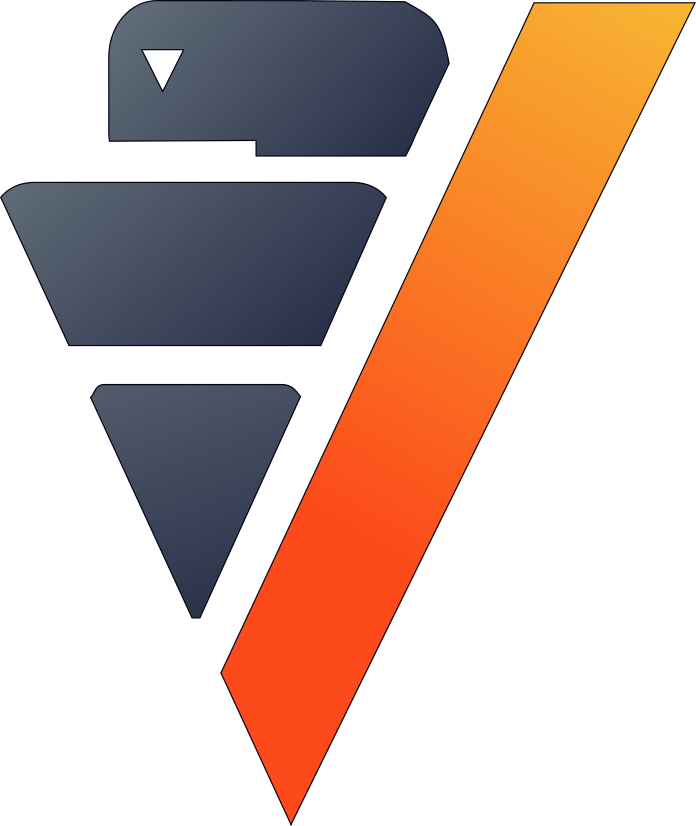

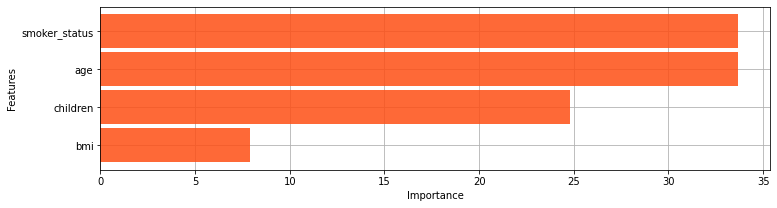

In [57]:
# define the random forest model
prod_rf_model = RandomForestClassifier(name="insurance.prod_randf_model_insurance",
                                       n_estimators=25,
                                       max_features="auto",
                                       max_leaf_nodes=70,
                                       sample=1.0,
                                       max_depth=6,
                                       min_samples_leaf=2,
                                       min_info_gain=0.0,
                                       nbins=32)
# selected features
prod_predictors = ['smoker_status', 'bmi', 'age', 'children']
target = "insurance_plan"
# train the model
prod_rf_model.fit(train_data,
                  prod_predictors,
                  target)

# feature importance for our random forest model
prod_rf_model.features_importance()

In [58]:
print("Random Forest Model Results:\n")
evaluation_report(prod_rf_model, test_data,
                  prediction_label="prod_prediction",
                  predictors=prod_predictors)

Random Forest Model Results:

         Recall          Precision  F1-score  
bronze   0.98            0.931      0.955     
silver   0.781           0.82       0.8       
gold     0.912           0.981      0.945     
platinum 0.735           0.893      0.806     

Accuracy   Marco-Recall    Marco-Precision      Macro-F1             Weighted-F1          Kappa Score (Q)     

0.918      0.852           0.906                0.877                0.916                0.898               
